# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
pd.options.display.max_columns
pd.options.display.max_columns = 200
pd.options.display.max_rows = 300

# Gather Data

In [3]:
data = pd.read_csv('/Users/kb/Ironhack/Labs/data_mid_bootcamp_project_classification/creditcardmarketing.csv')
data.head()

,1,No,Air Miles,Letter,High,1.1,No.1,High.1,2,1.2,4,No.2,1160.75,1669,877,1095,1002
0,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
1,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
2,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
3,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0
4,6,No,Air Miles,Letter,Medium,1,No,High,3,1,4,No,1114.75,1847.0,1365.0,750.0,497.0


In [4]:
data.columns = ['customer number','offer accepted','purchase method','mailer type','income level','bank accounts open','overdraft protection','credit rating','credit cards held','homes owned','household size','own your home','average balance','balance-q1','balance-q2','balance-q3','balance-q4']
data.columns

Index(['customer number', 'offer accepted', 'purchase method', 'mailer type',
       'income level', 'bank accounts open', 'overdraft protection',
       'credit rating', 'credit cards held', 'homes owned', 'household size',
       'own your home', 'average balance', 'balance-q1', 'balance-q2',
       'balance-q3', 'balance-q4'],
      dtype='object')

In [5]:
data.drop_duplicates(inplace=True)

# Explore the Data

In [6]:
data.dtypes

customer number           int64
offer accepted           object
purchase method          object
mailer type              object
income level             object
bank accounts open        int64
overdraft protection     object
credit rating            object
credit cards held         int64
homes owned               int64
household size            int64
own your home            object
average balance         float64
balance-q1              float64
balance-q2              float64
balance-q3              float64
balance-q4              float64
dtype: object

In [7]:
data.shape

(17999, 17)

### Checking for nulls

In [8]:
x=pd.DataFrame(data.isna().sum()/len(data)*100).reset_index()
x

,index,0
0,customer number,0.000000
1,offer accepted,0.000000
2,purchase method,0.000000
3,mailer type,0.000000
4,income level,0.000000
5,bank accounts open,0.000000
6,overdraft protection,0.000000
7,credit rating,0.000000
8,credit cards held,0.000000
9,homes owned,0.000000


In [9]:
#due to low number of null rows (0.13%) and time constraints, I'm choosing to drop NA rows
data=data.dropna(axis =0)
data.shape

(17975, 17)

In [10]:
num = data.select_dtypes(np.number).drop(['customer number'], axis=1)
cont=[]
disc=[]
for i in num.columns:
    if data[i].nunique()/len(data)<.015:
        disc.append(i)
    else:
        cont.append(i)
print(cont)
print(disc)
continuous=data[cont]
continuous.head()
discrete=data[disc]
discrete.head()
cat=data.select_dtypes(np.object)
obs=pd.DataFrame(np.concatenate((cat, discrete), axis=1))
discrete.head()
obcol=cat.columns.append(discrete.columns)
obcol
obs.columns=obcol
obs.head()

['average balance', 'balance-q1', 'balance-q2', 'balance-q3', 'balance-q4']
['bank accounts open', 'credit cards held', 'homes owned', 'household size']


,offer accepted,purchase method,mailer type,income level,overdraft protection,credit rating,own your home,bank accounts open,credit cards held,homes owned,household size
0,No,Air Miles,Letter,Medium,No,Medium,Yes,1,2,2,5
1,No,Air Miles,Postcard,High,No,Medium,Yes,2,2,1,2
2,No,Air Miles,Letter,Medium,No,High,No,2,1,1,4
3,No,Air Miles,Letter,Medium,No,Medium,Yes,1,2,1,6
4,No,Air Miles,Letter,Medium,No,High,No,1,3,1,4


In [11]:
data.to_csv('/Users/kb/Ironhack/Labs/data_mid_bootcamp_project_classification/creditcardmarketingfinal.csv', index = False)

# Checking categorical columns

offer accepted


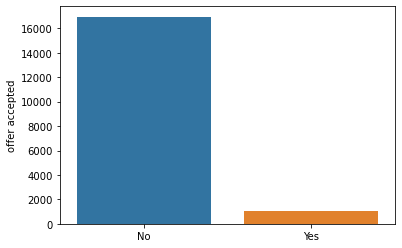

purchase method


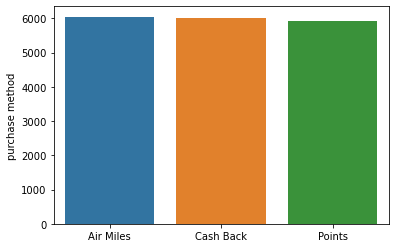

mailer type


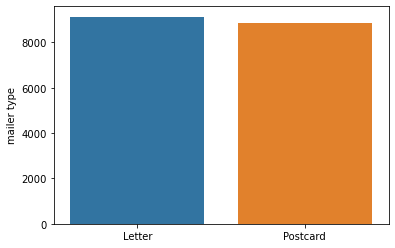

income level


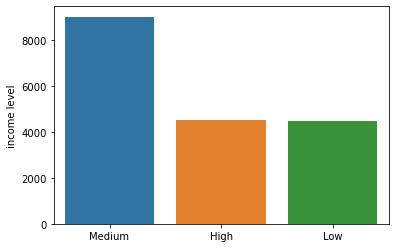

overdraft protection


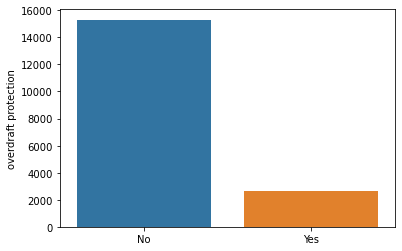

credit rating


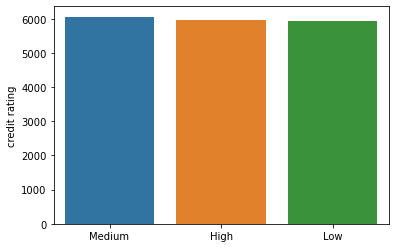

own your home


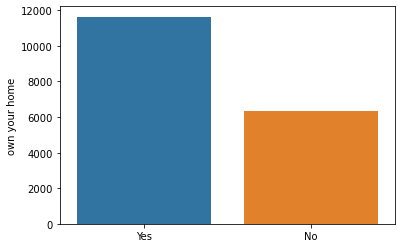

bank accounts open


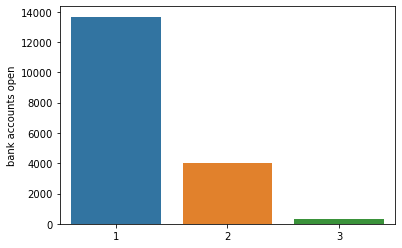

credit cards held


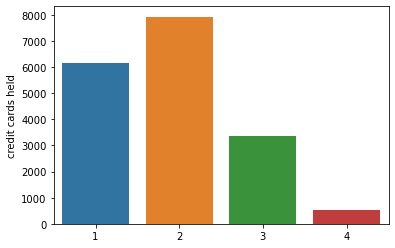

homes owned


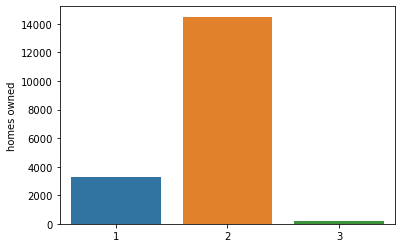

household size


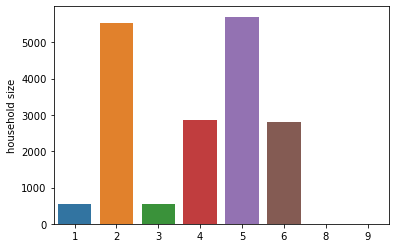

In [12]:
for i in obs.columns:
    print(i)
    sns.barplot( x=obs[i].unique(), y=obs[i].value_counts(), data=obs)
    plt.show()
#based on the output, i notice 2 main things and several less important things
#1. the data will need to be balanced. Nos far outweigh the yeses
#2. there are many categories of household size, so id like to reduce those
#3. bank accounts open, credit cards held, homes owned all have categories with low value counts that id like to evaluate to see whether they could be groups

In [13]:
q=pd.DataFrame(obs[obs['offer accepted']=="Yes"].groupby('household size').count()['offer accepted'])
q

,offer accepted
household size,
1,43
2,151
3,344
4,310
5,145
6,27
9,1


In [14]:
w=pd.DataFrame(obs.groupby('household size').count()['offer accepted'])
w

,offer accepted
household size,
1,539
2,2809
3,5705
4,5531
5,2851
6,538
8,1
9,1


In [15]:
q=q.merge(w, how='right', left_on='household size', right_on='household size').reset_index()
q

,household size,offer accepted_x,offer accepted_y
0,1,43.0,539
1,2,151.0,2809
2,3,344.0,5705
3,4,310.0,5531
4,5,145.0,2851
5,6,27.0,538
6,8,NaN,1
7,9,1.0,1


In [16]:
q['offer accepted_x']=q['offer accepted_x'].fillna(0)

In [17]:
def acceptance_rate(x,y):
    z=x/y
    return z

In [18]:
q['acceptance_rate'] = list(map(acceptance_rate, q['offer accepted_x'], q['offer accepted_y']))
q=q[q['household size']<8]
q

,household size,offer accepted_x,offer accepted_y,acceptance_rate
0,1,43.0,539,0.079777
1,2,151.0,2809,0.053756
2,3,344.0,5705,0.060298
3,4,310.0,5531,0.056048
4,5,145.0,2851,0.050859
5,6,27.0,538,0.050186


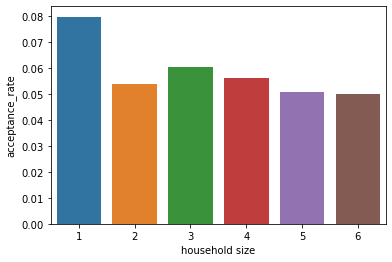

In [19]:
sns.barplot( x=q['household size'], y=q['acceptance_rate'], data=q)
plt.show()
#this plt shows 5 and 6 are super similar. so im going to group 5+ all together

In [20]:
def hhsize(x):
    if x>4:
        return '5+'
    else:
        return x

In [21]:
data['household size']=list(map(hhsize, data['household size']))

In [22]:
q=pd.DataFrame(obs[obs['offer accepted']=="Yes"].groupby('bank accounts open').count()['offer accepted'])
q

,offer accepted
bank accounts open,
1,775
2,234
3,12


In [23]:
w=pd.DataFrame(obs.groupby('bank accounts open').count()['offer accepted'])
w

,offer accepted
bank accounts open,
1,13673
2,4007
3,295


In [24]:
q=q.merge(w, how='right', left_on='bank accounts open', right_on='bank accounts open').reset_index()
q

,bank accounts open,offer accepted_x,offer accepted_y
0,1,775,13673
1,2,234,4007
2,3,12,295


In [25]:
q['acceptance_rate'] = list(map(acceptance_rate, q['offer accepted_x'], q['offer accepted_y']))
q

,bank accounts open,offer accepted_x,offer accepted_y,acceptance_rate
0,1,775,13673,0.056681
1,2,234,4007,0.058398
2,3,12,295,0.040678


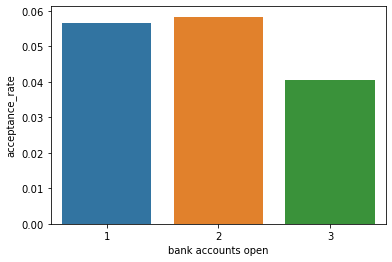

In [26]:
sns.barplot( x=q['bank accounts open'], y=q['acceptance_rate'], data=q)
plt.show()
#3 has much lower rate so im not going to merge it with anything dispite low value counts

   credit cards held  offer accepted_x  offer accepted_y  acceptance_rate
0                  1               361              6147         0.058728
1                  2               433              7932         0.054589
2                  3               198              3381         0.058563
3                  4                29               515         0.056311


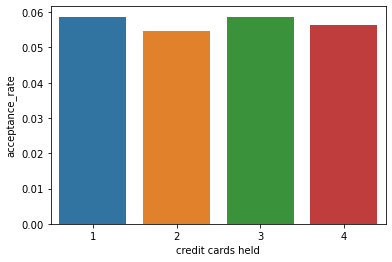

In [27]:
q=pd.DataFrame(obs[obs['offer accepted']=="Yes"].groupby('credit cards held').count()['offer accepted'])
w=pd.DataFrame(obs.groupby('credit cards held').count()['offer accepted'])
q=q.merge(w, how='right', left_on='credit cards held', right_on='credit cards held').reset_index()
q['acceptance_rate'] = list(map(acceptance_rate, q['offer accepted_x'], q['offer accepted_y']))
print(q)
sns.barplot( x=q['credit cards held'], y=q['acceptance_rate'], data=q)
plt.show()


In [28]:
def ccheld(x):
    if (x == 4) or (x==2):
        return '2&4'
    else:
        return '1&3'

In [29]:
data['credit cards held']=list(map(ccheld, data['credit cards held']))

   homes owned  offer accepted_x  offer accepted_y  acceptance_rate
0            1               823             14501         0.056755
1            2               189              3289         0.057464
2            3                 9               185         0.048649


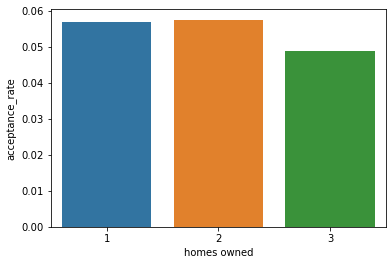

In [30]:
q=pd.DataFrame(obs[obs['offer accepted']=="Yes"].groupby('homes owned').count()['offer accepted'])
w=pd.DataFrame(obs.groupby('homes owned').count()['offer accepted'])
q=q.merge(w, how='right', left_on='homes owned', right_on='homes owned').reset_index()
q['acceptance_rate'] = list(map(acceptance_rate, q['offer accepted_x'], q['offer accepted_y']))
print(q)
sns.barplot( x=q['homes owned'], y=q['acceptance_rate'], data=q)
plt.show()


In [31]:
#chosing not to clean, 3s are too different from 1-2 to group, but 185 rows is more than i care to delete
data['homes owned'].value_counts()

1    14501
2     3289
3      185
Name: homes owned, dtype: int64

In [32]:
#now going to reseparate my data types given current changes
num = data.select_dtypes(np.number).drop(['customer number'], axis=1)
cont=[]
disc=[]
for i in num.columns:
    if data[i].nunique()/len(data)<.015:
        disc.append(i)
    else:
        cont.append(i)
print(cont)
print(disc)
continuous=data[cont]
continuous.head()
discrete=data[disc]
discrete.head()
cat=data.select_dtypes(np.object)
obs=pd.DataFrame(np.concatenate((cat, discrete), axis=1))
discrete.head()
obcol=cat.columns.append(discrete.columns)
obcol
obs.columns=obcol
obs.head()

['average balance', 'balance-q1', 'balance-q2', 'balance-q3', 'balance-q4']
['bank accounts open', 'homes owned']


,offer accepted,purchase method,mailer type,income level,overdraft protection,credit rating,credit cards held,household size,own your home,bank accounts open,homes owned
0,No,Air Miles,Letter,Medium,No,Medium,2&4,5+,Yes,1,2
1,No,Air Miles,Postcard,High,No,Medium,2&4,2,Yes,2,1
2,No,Air Miles,Letter,Medium,No,High,1&3,4,No,2,1
3,No,Air Miles,Letter,Medium,No,Medium,2&4,5+,Yes,1,1
4,No,Air Miles,Letter,Medium,No,High,1&3,4,No,1,1


offer accepted


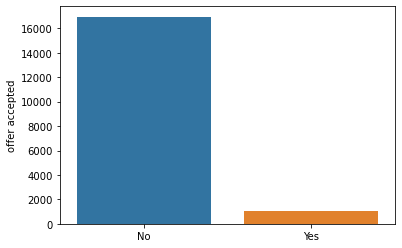

purchase method


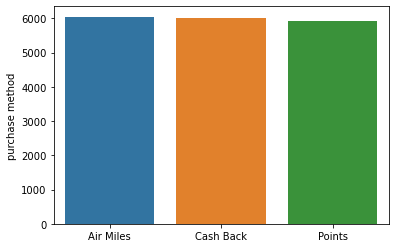

mailer type


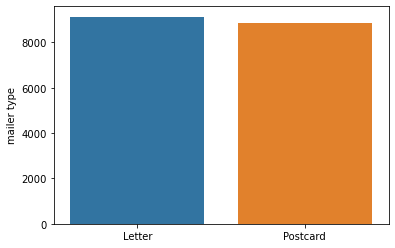

income level


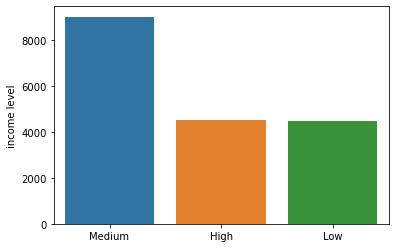

overdraft protection


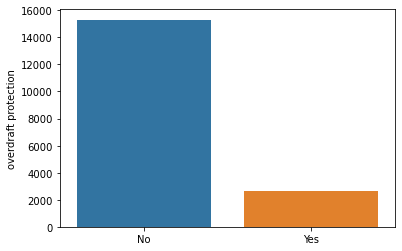

credit rating


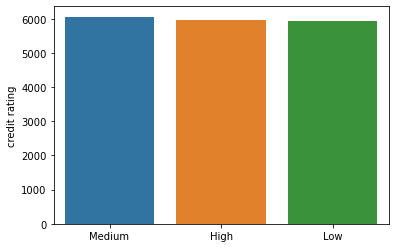

credit cards held


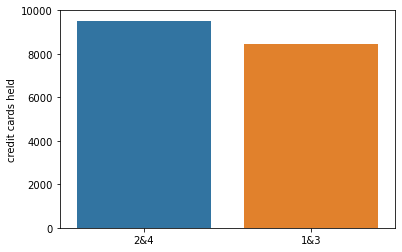

household size


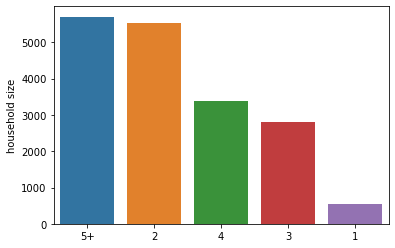

own your home


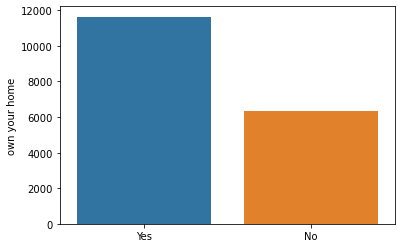

bank accounts open


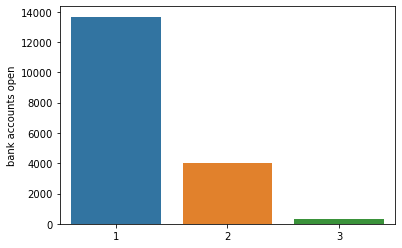

homes owned


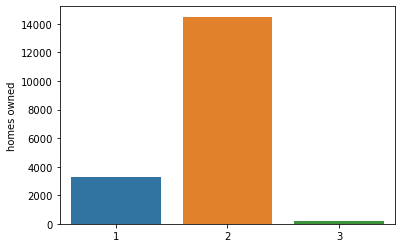

In [33]:
for i in obs.columns:
    print(i)
    sns.barplot( x=obs[i].unique(), y=obs[i].value_counts(), data=obs)
    plt.show()

# Checking numerical columns

In [34]:
continuous.dtypes

average balance    float64
balance-q1         float64
balance-q2         float64
balance-q3         float64
balance-q4         float64
dtype: object

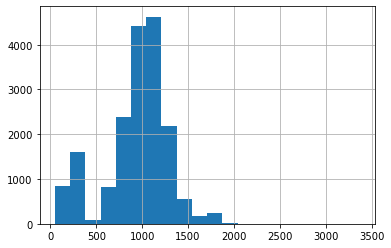

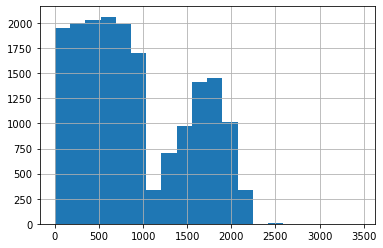

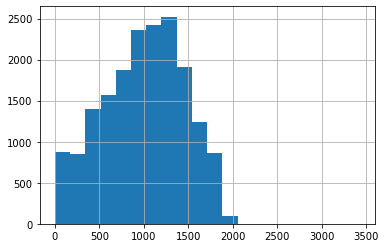

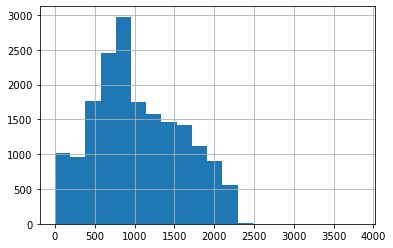

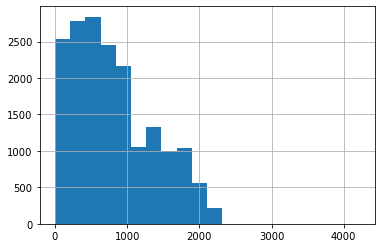

In [35]:
for i in continuous.columns:
    continuous[i].hist(bins=20)
    plt.show()

# Dealing with outliers

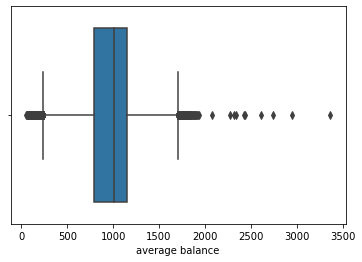

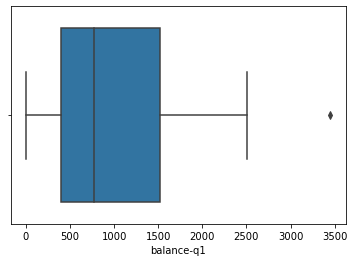

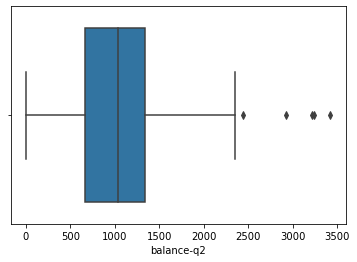

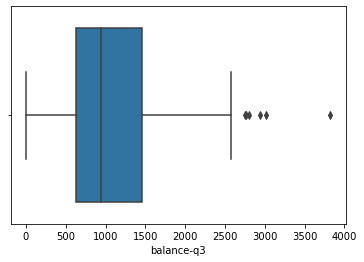

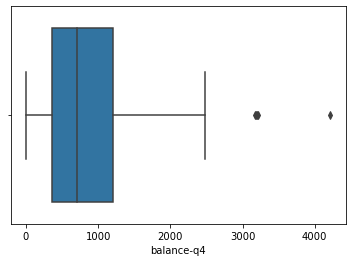

In [36]:
for i in continuous.columns:
    sns.boxplot(continuous[i])
    plt.show()

In [37]:
var_char={}
for i in data.columns:
    if i in list(continuous.columns):
        iqr = np.percentile(data[i],75)-np.percentile(data[i],25)
        var_char['upperlimit'+str(i)]=np.percentile(data[i],75)+iqr*1.5
        var_char['lowerlimit'+str(i)]=np.percentile(data[i],25)-iqr*1.5
        print(i, iqr, var_char['upperlimit'+str(i)], var_char['lowerlimit'+str(i)], data.shape)

average balance 365.625 1701.5625 239.0625 (17975, 17)
balance-q1 1128.5 3213.75 -1300.25 (17975, 17)
balance-q2 679.0 2360.5 -355.5 (17975, 17)
balance-q3 830.0 2708.0 -612.0 (17975, 17)
balance-q4 849.0 2485.5 -910.5 (17975, 17)


In [38]:
for i in data.columns:
    if i in list(continuous.columns):
        if var_char['upperlimit'+str(i)] != var_char['lowerlimit'+str(i)]:
            data=data[(data[i]>var_char['lowerlimit'+str(i)]) & (data[i]<var_char['upperlimit'+str(i)])]
        print(i, iqr, var_char['upperlimit'+str(i)], var_char['lowerlimit'+str(i)], data.shape)

average balance 849.0 1701.5625 239.0625 (16528, 17)
balance-q1 849.0 3213.75 -1300.25 (16528, 17)
balance-q2 849.0 2360.5 -355.5 (16528, 17)
balance-q3 849.0 2708.0 -612.0 (16528, 17)
balance-q4 849.0 2485.5 -910.5 (16527, 17)


In [39]:
#row level changes require re-separating data
num = data.select_dtypes(np.number).drop(['customer number'], axis=1)
cont=[]
disc=[]
for i in num.columns:
    if data[i].nunique()/len(data)<.015:
        disc.append(i)
    else:
        cont.append(i)
print(cont)
print(disc)
continuous=data[cont]
discrete=data[disc]
cat=data.select_dtypes(np.object)
obs=pd.DataFrame(np.concatenate((cat, discrete), axis=1))
obcol=cat.columns.append(discrete.columns)
obs.columns=obcol
obs.head()

['average balance', 'balance-q1', 'balance-q2', 'balance-q3', 'balance-q4']
['bank accounts open', 'homes owned']


,offer accepted,purchase method,mailer type,income level,overdraft protection,credit rating,credit cards held,household size,own your home,bank accounts open,homes owned
0,No,Air Miles,Postcard,High,No,Medium,2&4,2,Yes,2,1
1,No,Air Miles,Letter,Medium,No,High,1&3,4,No,2,1
2,No,Air Miles,Letter,Medium,No,Medium,2&4,5+,Yes,1,1
3,No,Air Miles,Letter,Medium,No,High,1&3,4,No,1,1
4,No,Air Miles,Letter,Medium,No,Medium,2&4,3,No,1,1


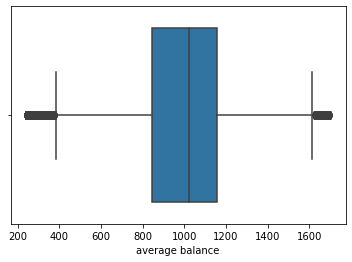

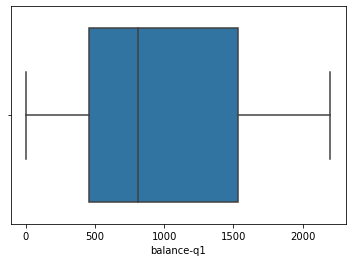

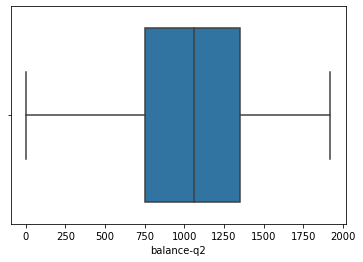

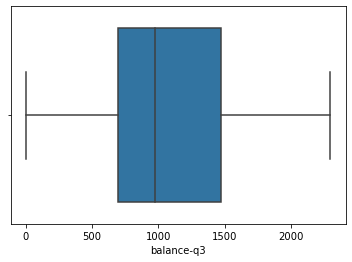

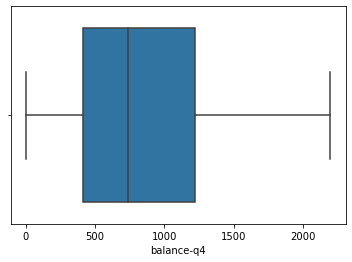

In [40]:
for i in continuous.columns:
    sns.boxplot(continuous[i])
    plt.show()

# Data Transformations

In [41]:
continuous2=continuous.copy()

In [42]:
def log_transfom_clean_(x):
    if np.isfinite(x) and x>0:
        return np.log(x)
    else:
        return np.NAN

In [43]:
for i in continuous.columns:
    continuous2[i]=list(map(log_transfom_clean_, continuous[i]))

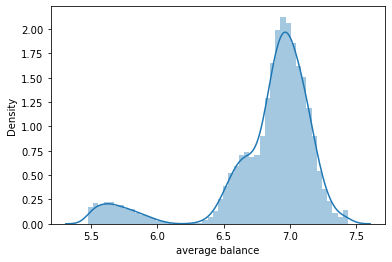

average balance


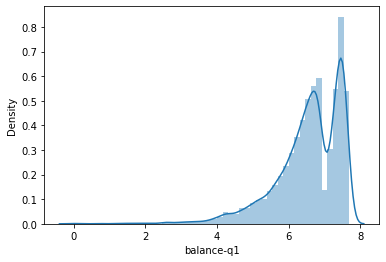

balance-q1


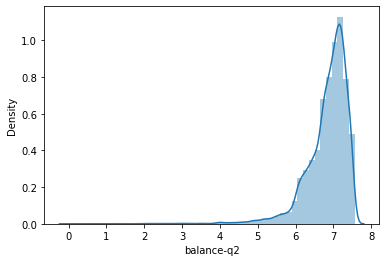

balance-q2


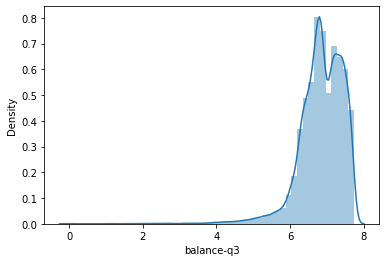

balance-q3


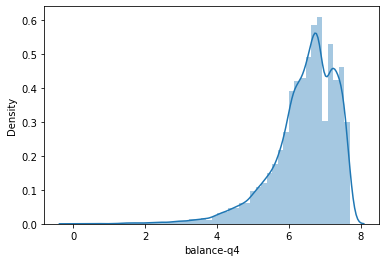

balance-q4


In [44]:
for i in continuous.columns:
    sns.distplot(continuous2[i])
    plt.show()
    print(i)
#log transformation makes my data too left skewed

In [45]:
def sqrt_transfom_clean_(x):
    if np.isfinite(x) and x>=0:
        return np.sqrt(x)
    else:
        return np.NAN

In [46]:
for i in continuous.columns:
    continuous2[i]=list(map(sqrt_transfom_clean_, continuous[i]))

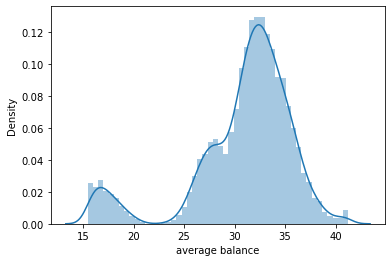

average balance


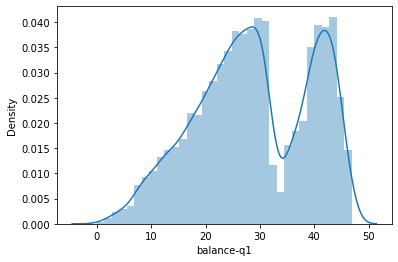

balance-q1


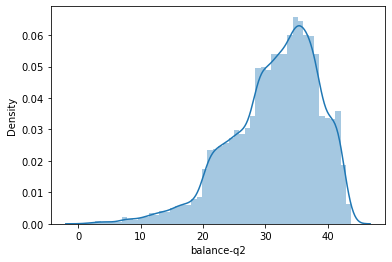

balance-q2


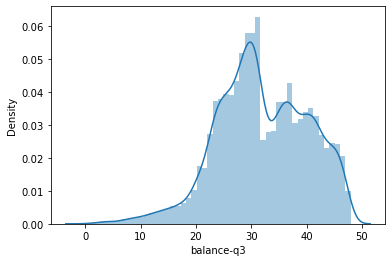

balance-q3


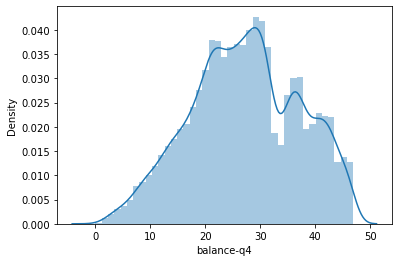

balance-q4


In [47]:
for i in continuous.columns:
    sns.distplot(continuous2[i])
    plt.show()
    print(i)
#best for 2,3,4 and 5 thus far

In [48]:
def sqr_transfom_clean_(x):
    if np.isfinite(x) and x>=0:
        return x**2
    else:
        return np.NAN

In [49]:
for i in continuous.columns:
    continuous2[i]=list(map(sqr_transfom_clean_, continuous[i]))

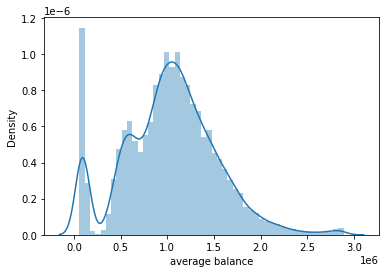

average balance


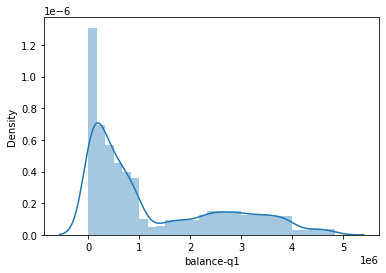

balance-q1


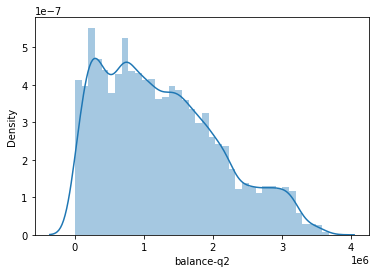

balance-q2


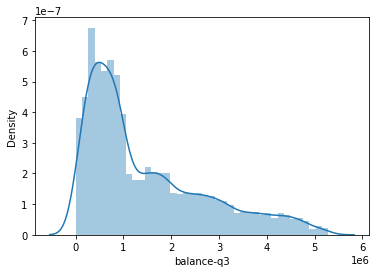

balance-q3


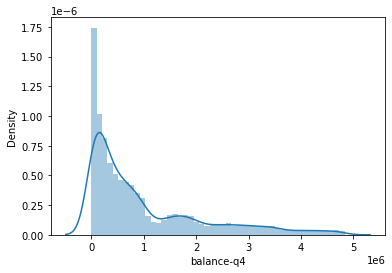

balance-q4


In [50]:
for i in continuous.columns:
    sns.distplot(continuous2[i])
    plt.show()
    print(i)
    #maybe best for first one

In [51]:
def cbd_transfom_clean_(x):
    if np.isfinite(x) and x>=0:
        return x**3
    else:
        return np.NAN

In [52]:
for i in continuous.columns:
    continuous2[i]=list(map(cbd_transfom_clean_, continuous[i]))

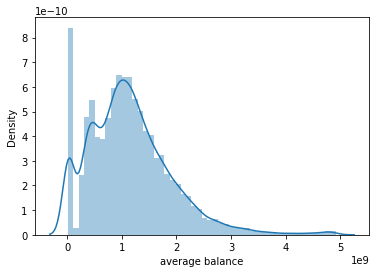

average balance


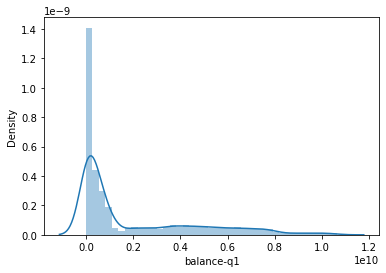

balance-q1


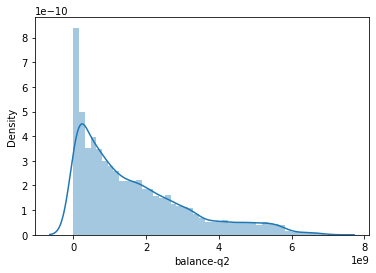

balance-q2


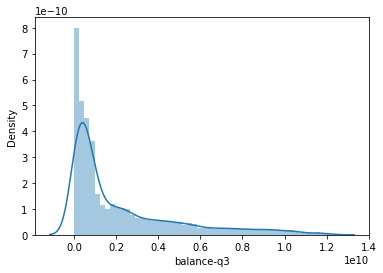

balance-q3


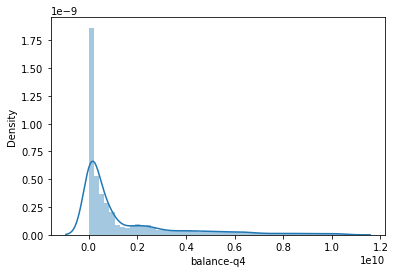

balance-q4


In [53]:
for i in continuous.columns:
    sns.distplot(continuous2[i])
    plt.show()
    print(i)

In [54]:
for i in continuous.columns:
    continuous2[i]=list(map(sqrt_transfom_clean_, continuous2[i]))

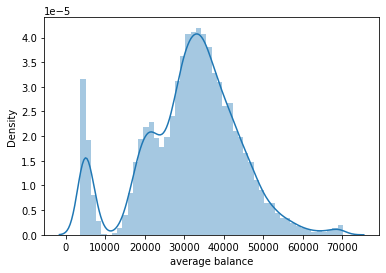

average balance


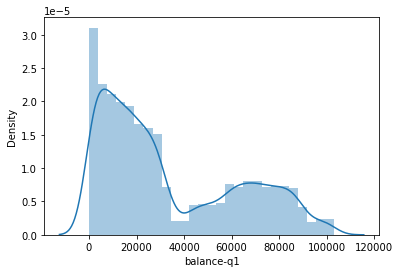

balance-q1


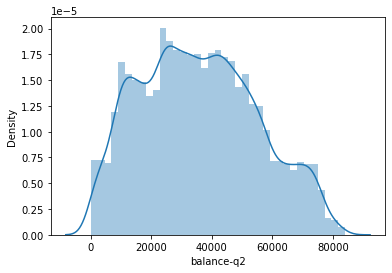

balance-q2


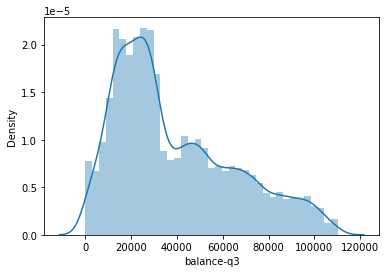

balance-q3


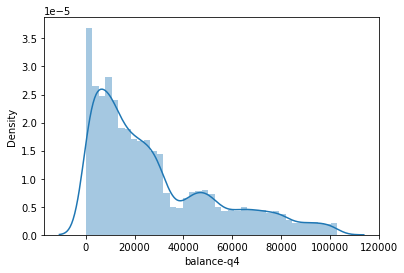

balance-q4


In [55]:
for i in continuous.columns:
    sns.distplot(continuous2[i])
    plt.show()
    print(i)

In [56]:
continuous3=continuous.copy()

In [57]:
for i in continuous.columns:
    continuous3[i]=list(map(log_transfom_clean_, continuous2[i]))

average balance


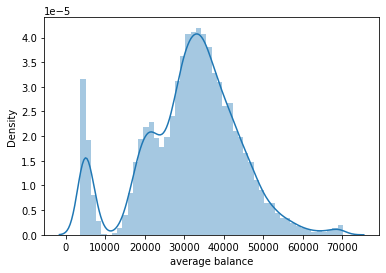

balance-q1


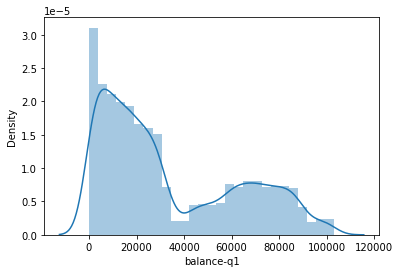

balance-q2


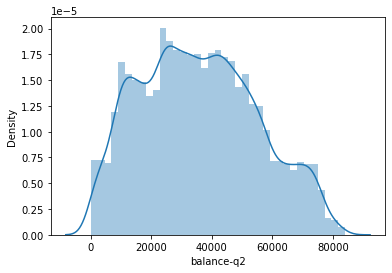

balance-q3


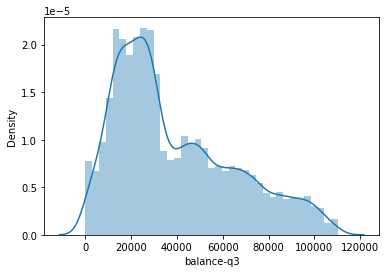

balance-q4


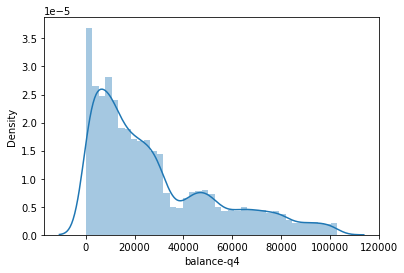

In [58]:
for i in continuous.columns:
    print(i)
    sns.distplot(continuous2[i])
    plt.show()

In [59]:
continuous['average balance']=list(map(sqr_transfom_clean_, continuous['average balance']))

In [60]:
for i in np.arange(continuous.shape[1])[1:]:
    continuous[continuous.columns[i]]=list(map(sqrt_transfom_clean_, continuous[continuous.columns[i]]))
    print(continuous[continuous.columns[i]])

1        19.157244
2        39.724048
3        46.260134
4        42.976738
5        21.633308
           ...    
17993    17.175564
17995    31.368774
17996    30.298515
17997    25.019992
17998    16.278821
Name: balance-q1, Length: 16527, dtype: float64
1        18.761663
2        41.952354
3        36.837481
4        36.945906
5        13.711309
           ...    
17993    30.282008
17995    30.659419
17996    27.694765
17997    31.352831
17998    37.121422
Name: balance-q2, Length: 16527, dtype: float64
1        12.041595
2        33.451457
3        31.336879
4        27.386128
5        18.627936
           ...    
17993    40.099875
17995    30.708305
17996    34.205263
17997    29.410882
17998    44.474712
Name: balance-q3, Length: 16527, dtype: float64
1        15.556349
2        20.469489
3        19.104973
4        22.293497
5        11.489125
           ...    
17993    33.481338
17995    23.130067
17996    38.652296
17997    40.187063
17998    24.556058
Name: balance-q4, Le

average balance


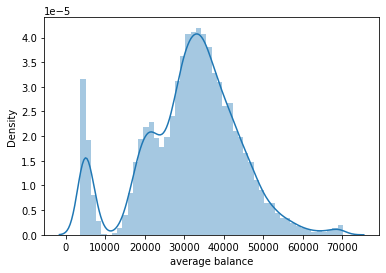

balance-q1


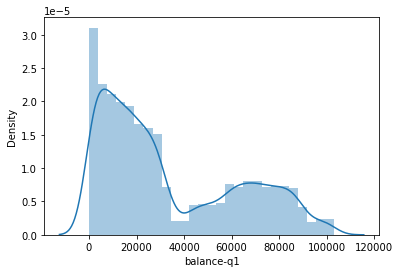

balance-q2


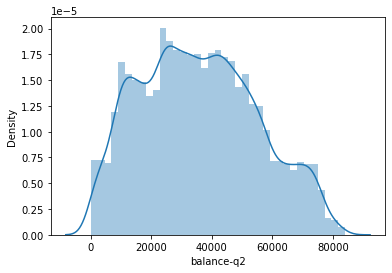

balance-q3


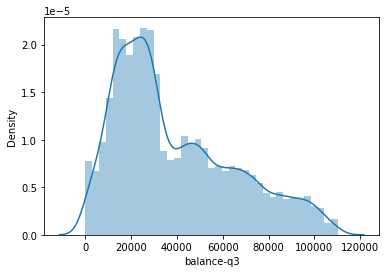

balance-q4


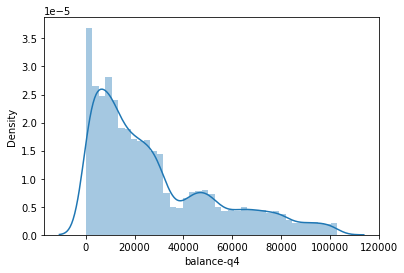

In [61]:
for i in continuous.columns:
    print(i)
    sns.distplot(continuous2[i])
    plt.show()

In [62]:
#need to ensure there arent nans created by negative or 0 values
x=pd.DataFrame(continuous.isna().sum()/len(continuous)*100).reset_index()
x

,index,0
0,average balance,0.0
1,balance-q1,0.0
2,balance-q2,0.0
3,balance-q3,0.0
4,balance-q4,0.0


# Dealing with multicolinearity

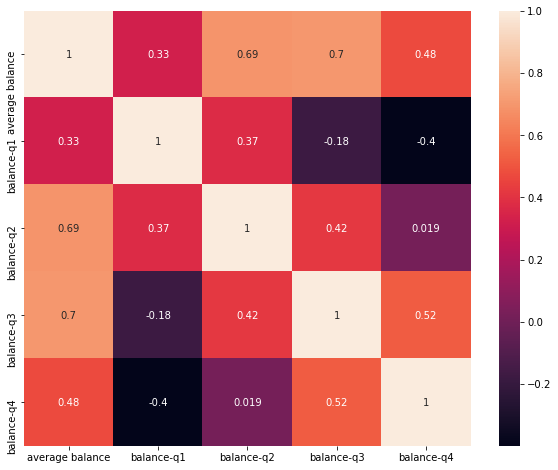

In [63]:
data_corr = continuous
corr_matrix=data_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()
#the highest Correlation is only .7 so i think it is fine to keep all regressors

<AxesSubplot:xlabel='average balance', ylabel='balance-q3'>

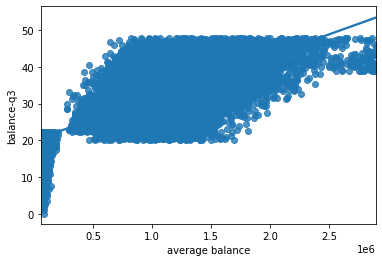

In [64]:
sns.regplot('average balance','balance-q3', data=data_corr)

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# all vifs less than 50
vif = {}
for i in np.arange(data_corr.shape[1]):
    column_name = data_corr.columns[i]
    value = variance_inflation_factor(np.array(data_corr), i)
    vif[column_name] = value
    
vif

{'average balance': 11.788654357614666,
 'balance-q1': 10.266372311835703,
 'balance-q2': 32.12160869347864,
 'balance-q3': 30.408212345689236,
 'balance-q4': 11.963814800081373}

# Transforming numerical columns with different transformers

### Standardization

In [66]:
# Standardization/Standard Scaler

from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(continuous)
x_standardized = transformer.transform(continuous)
x_standardized

array([[-1.92484784, -0.91950779, -1.82592969, -2.43042553, -1.18179509],
       [ 0.89723041,  1.0223982 ,  1.48954884,  0.17995398, -0.68351839],
       [ 0.8583082 ,  1.63953173,  0.7582963 , -0.07786418, -0.82190375],
       ...,
       [ 0.28887373,  0.13244468, -0.54880055,  0.27186107,  1.16053009],
       [ 0.01434098, -0.36595045, -0.02582177, -0.31268973,  1.31618173],
       [ 0.15477516, -1.19128691,  0.79889025,  1.52395503, -0.26907022]])

### Scaling

In [67]:
# Min max scaler

from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(continuous)
x_min_max = transformer.transform(continuous)
x_min_max

array([[0.00677587, 0.40843382, 0.41493016, 0.25113921, 0.33173788],
       [0.50390273, 0.84691955, 0.95668782, 0.69766279, 0.4365102 ],
       [0.49704633, 0.98626937, 0.83719928, 0.6535612 , 0.407412  ],
       ...,
       [0.39673686, 0.64596651, 0.62361632, 0.71338413, 0.82425708],
       [0.34837619, 0.53342802, 0.70907239, 0.61339265, 0.85698584],
       [0.37311456, 0.34706562, 0.84383244, 0.92756352, 0.52365595]])

### Normalization

In [68]:
# Normalization

from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(continuous)
x_normalized = transformer.transform(continuous)
x_normalized

array([[9.99999905e-01, 2.50577874e-04, 2.45403651e-04, 1.57504762e-04,
        2.03477958e-04],
       [9.99999999e-01, 2.67329009e-05, 2.82324730e-05, 2.25116657e-05,
        1.37752535e-05],
       [9.99999999e-01, 3.15441333e-05, 2.51189590e-05, 2.13681762e-05,
        1.30274119e-05],
       ...,
       [9.99999998e-01, 2.56308204e-05, 2.34281960e-05, 2.89357070e-05,
        3.26976443e-05],
       [9.99999998e-01, 2.39426892e-05, 3.00028506e-05, 2.81445179e-05,
        3.84567009e-05],
       [9.99999998e-01, 1.45980585e-05, 3.32886951e-05, 3.98827693e-05,
        2.20206847e-05]])

### Method Selector

In [69]:
num = pd.DataFrame(x_standardized)
num.columns=continuous.columns

In [70]:
num
obs.shape

(16527, 11)

# Balancing Data

In [71]:
obs.columns

Index(['offer accepted', 'purchase method', 'mailer type', 'income level',
       'overdraft protection', 'credit rating', 'credit cards held',
       'household size', 'own your home', 'bank accounts open', 'homes owned'],
      dtype='object')

In [72]:
data2=pd.DataFrame(np.concatenate((obs, num), axis=1))
obcol=obs.columns.append(num.columns)
obcol
data2.columns=obcol
data2.head()

,offer accepted,purchase method,mailer type,income level,overdraft protection,credit rating,credit cards held,household size,own your home,bank accounts open,homes owned,average balance,balance-q1,balance-q2,balance-q3,balance-q4
0,No,Air Miles,Postcard,High,No,Medium,2&4,2,Yes,2,1,-1.924848,-0.919508,-1.82593,-2.430426,-1.181795
1,No,Air Miles,Letter,Medium,No,High,1&3,4,No,2,1,0.89723,1.022398,1.489549,0.179954,-0.683518
2,No,Air Miles,Letter,Medium,No,Medium,2&4,5+,Yes,1,1,0.858308,1.639532,0.758296,-0.077864,-0.821904
3,No,Air Miles,Letter,Medium,No,High,1&3,4,No,1,1,0.410115,1.329515,0.773797,-0.559556,-0.498533
4,No,Air Miles,Letter,Medium,No,Medium,2&4,3,No,1,1,-1.916715,-0.685719,-2.547958,-1.627391,-1.594281


In [73]:
y = data2['offer accepted']
y.value_counts()

No     15593
Yes      934
Name: offer accepted, dtype: int64

In [74]:
x=data2.drop(['offer accepted'], axis=1)

### Random Oversample

In [75]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x, y)
y_over.value_counts()

No     15593
Yes    15593
Name: offer accepted, dtype: int64

### Random Undersample

In [76]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
x_under, y_under = undersample.fit_resample(x, y)
y_under.value_counts()

No     934
Yes    934
Name: offer accepted, dtype: int64

### Synthetic Minority Oversampling TEchnique (SMOTE)

In [77]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
xsm, ysm = smote.fit_resample(num, y)
ysm.value_counts()

No     15593
Yes    15593
Name: offer accepted, dtype: int64

### UnderSampling using TomekLinks

In [78]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks('majority')
xtl, ytl = tl.fit_resample(num, y)
ytl.value_counts()

No     15110
Yes      934
Name: offer accepted, dtype: int64

In [79]:
xtl2, ytl2 = tl.fit_resample(xtl, ytl)
ytl2.value_counts()

No     14918
Yes      934
Name: offer accepted, dtype: int64

### Select Sample

In [80]:
y=pd.DataFrame(y_over)
x=pd.DataFrame(x_over)

In [81]:
x.dtypes

purchase method         object
mailer type             object
income level            object
overdraft protection    object
credit rating           object
credit cards held       object
household size          object
own your home           object
bank accounts open      object
homes owned             object
average balance         object
balance-q1              object
balance-q2              object
balance-q3              object
balance-q4              object
dtype: object

In [82]:
for i in x.columns:
    for a in continuous.columns:
        if i== a:
            print(a)
            x[i]=pd.to_numeric(x[i],errors='coerce')
            

average balance
balance-q1
balance-q2
balance-q3
balance-q4


In [83]:
x.dtypes

purchase method          object
mailer type              object
income level             object
overdraft protection     object
credit rating            object
credit cards held        object
household size           object
own your home            object
bank accounts open       object
homes owned              object
average balance         float64
balance-q1              float64
balance-q2              float64
balance-q3              float64
balance-q4              float64
dtype: object

In [84]:
num = x.select_dtypes(np.number)
cont=[]
disc=[]
for i in num.columns:
    print(x_over[i].nunique()/len(x_over))
    if x_over[i].nunique()/len(x_over)<.015:
        disc.append(i)
    else:
        cont.append(i)
print(cont)
print(disc)
continuous=x[cont]
discrete=x[disc]
cat=x.select_dtypes(np.object)
obs=pd.DataFrame(np.concatenate((cat, discrete), axis=1))
obcol=cat.columns.append(discrete.columns)
obs.columns=obcol
obs.head()

0.12880779837106393
0.06894119156031553
0.0588084396844738
0.07176297056371449
0.0696145706406721
['average balance', 'balance-q1', 'balance-q2', 'balance-q3', 'balance-q4']
[]


,purchase method,mailer type,income level,overdraft protection,credit rating,credit cards held,household size,own your home,bank accounts open,homes owned
0,Air Miles,Postcard,High,No,Medium,2&4,2,Yes,2,1
1,Air Miles,Letter,Medium,No,High,1&3,4,No,2,1
2,Air Miles,Letter,Medium,No,Medium,2&4,5+,Yes,1,1
3,Air Miles,Letter,Medium,No,High,1&3,4,No,1,1
4,Air Miles,Letter,Medium,No,Medium,2&4,3,No,1,1


In [85]:
num.columns

Index(['average balance', 'balance-q1', 'balance-q2', 'balance-q3',
       'balance-q4'],
      dtype='object')

# Encoding categorical values

In [86]:
for i in obs.columns:
    obs[i] = obs[i].astype(str)

In [87]:
encoder= OneHotEncoder(handle_unknown='error').fit(obs)
encoded=encoder.transform(obs).toarray()

In [88]:
encoded=pd.DataFrame(encoded)
encoded.columns=encoder.get_feature_names()
encoded.columns

Index(['x0_Air Miles', 'x0_Cash Back', 'x0_Points', 'x1_Letter', 'x1_Postcard',
       'x2_High', 'x2_Low', 'x2_Medium', 'x3_No', 'x3_Yes', 'x4_High',
       'x4_Low', 'x4_Medium', 'x5_1&3', 'x5_2&4', 'x6_1', 'x6_2', 'x6_3',
       'x6_4', 'x6_5+', 'x7_No', 'x7_Yes', 'x8_1', 'x8_2', 'x8_3', 'x9_1',
       'x9_2', 'x9_3'],
      dtype='object')

### Adding columns names back to the concatinated dataset

In [89]:
xcols=continuous.columns.append(encoded.columns)
continuous.columns
xcols

Index(['average balance', 'balance-q1', 'balance-q2', 'balance-q3',
       'balance-q4', 'x0_Air Miles', 'x0_Cash Back', 'x0_Points', 'x1_Letter',
       'x1_Postcard', 'x2_High', 'x2_Low', 'x2_Medium', 'x3_No', 'x3_Yes',
       'x4_High', 'x4_Low', 'x4_Medium', 'x5_1&3', 'x5_2&4', 'x6_1', 'x6_2',
       'x6_3', 'x6_4', 'x6_5+', 'x7_No', 'x7_Yes', 'x8_1', 'x8_2', 'x8_3',
       'x9_1', 'x9_2', 'x9_3'],
      dtype='object')

In [90]:
x = np.concatenate((continuous, encoded), axis=1)
pd.DataFrame(x).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,-1.924848,-0.919508,-1.825930,-2.430426,-1.181795,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.897230,1.022398,1.489549,0.179954,-0.683518,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.858308,1.639532,0.758296,-0.077864,-0.821904,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.410115,1.329515,0.773797,-0.559556,-0.498533,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-1.916715,-0.685719,-2.547958,-1.627391,-1.594281,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [91]:
x=pd.DataFrame(x)
x.columns=xcols
x.head()

,average balance,balance-q1,balance-q2,balance-q3,balance-q4,x0_Air Miles,x0_Cash Back,x0_Points,x1_Letter,x1_Postcard,x2_High,x2_Low,x2_Medium,x3_No,x3_Yes,x4_High,x4_Low,x4_Medium,x5_1&3,x5_2&4,x6_1,x6_2,x6_3,x6_4,x6_5+,x7_No,x7_Yes,x8_1,x8_2,x8_3,x9_1,x9_2,x9_3
0,-1.924848,-0.919508,-1.825930,-2.430426,-1.181795,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.897230,1.022398,1.489549,0.179954,-0.683518,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.858308,1.639532,0.758296,-0.077864,-0.821904,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.410115,1.329515,0.773797,-0.559556,-0.498533,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-1.916715,-0.685719,-2.547958,-1.627391,-1.594281,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Train Test Split

In [92]:
x.shape
x.head()

,average balance,balance-q1,balance-q2,balance-q3,balance-q4,x0_Air Miles,x0_Cash Back,x0_Points,x1_Letter,x1_Postcard,x2_High,x2_Low,x2_Medium,x3_No,x3_Yes,x4_High,x4_Low,x4_Medium,x5_1&3,x5_2&4,x6_1,x6_2,x6_3,x6_4,x6_5+,x7_No,x7_Yes,x8_1,x8_2,x8_3,x9_1,x9_2,x9_3
0,-1.924848,-0.919508,-1.825930,-2.430426,-1.181795,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.897230,1.022398,1.489549,0.179954,-0.683518,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.858308,1.639532,0.758296,-0.077864,-0.821904,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.410115,1.329515,0.773797,-0.559556,-0.498533,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-1.916715,-0.685719,-2.547958,-1.627391,-1.594281,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [93]:
y.shape
y['offer accepted'].value_counts()

No     15593
Yes    15593
Name: offer accepted, dtype: int64

In [94]:
xtrain, xtest, ytrain, ytest= train_test_split(x,y, test_size=0.3, random_state=100)

xtrain=pd.DataFrame(xtrain).reset_index(drop=True)
xtest=pd.DataFrame(xtest).reset_index(drop=True)
ytrain=pd.DataFrame(ytrain).reset_index(drop=True)
ytest=pd.DataFrame(ytest).reset_index(drop=True)
xtrain.columns=x.columns
xtest.columns=x.columns
y=pd.DataFrame(y)
ytrain.columns=y.columns
ytest.columns=y.columns

# Train Classification Model

In [95]:
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(xtrain, ytrain)

# Test Classification Model

In [96]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(xtest)

### Confusion Matrix

The accuracy of the model on test set is: 0.71 
[[3197 1534]
 [1224 3401]]


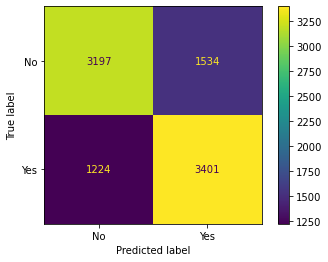

In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

print("The accuracy of the model on test set is: %4.2f " % accuracy_score(ytest, predictions))
print(confusion_matrix(ytest, predictions))
plot_confusion_matrix(classification, xtest, ytest)  


### Kappa Score

In [98]:
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(ytest, predictions)))

The Kappa of your model is: 0.41


### ROC AUC Score

In [99]:
roc_auc_score(ytest, classification.predict_proba(xtest)[:, 1])


0.7676625820493925

In [100]:
roc_auc_score(ytest, classification.decision_function(xtest))

0.7676625820493925

# Scaler and Sampling Method Selection Outcomes

In [104]:
from PIL import Image
image = Image.open("/Users/kb/Ironhack/Labs/data_mid_bootcamp_project_classification/table.png");
image.show()

#image shows the accuracy measures for each of the methods tried, 
#concludes that standard scaler and random over sampling produce 
#the best outcomes.